<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Смешивание-панорамных-изображений">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Смешивание панорамных изображений
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#3-Общий-вывод">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Лабораторная работа №7: Гомографии

**Задача:**

**Источник данных:**

Сделать панораму > чем на 2 чём-то там
Пример гомографии (не обрабатываются засветы)
поправить код
гомография на примере нелинейной поверхности (самим взять точки)
(автоматическое трангулирование)

+ обратно вернуть в цвет img

проблемы при загрузке больших изображений - настроить, чтобы принимался весь размер

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Установка недостающих библиотек:

In [1]:
%%capture no-display
!pip install opencv-python

Импорт библиотек:

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from typing import Tuple, List
from tqdm.notebook import tqdm
import os

import cv2

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Смешивание панорамных изображений

**Гомография** - это преобразование (матрица 3х3), которое отображает точки одного изображения в точки соответствия другого изображения.


$$ H = \begin{pmatrix}
h_{00} & h_{01} & h_{02}\\
h_{10} & h_{11} & h_{12}\\
h_{20} & h_{21} & h_{22}
\end{pmatrix} $$

Гомография отображает точки одного изображения в другом следующим образом:

$$ \begin{pmatrix}
x_i\\
y_i\\
1
\end{pmatrix} = H * \begin{pmatrix}
x_{i+1}\\
y_{i+1}\\
1
\end{pmatrix} = \begin{pmatrix}
h_{00} & h_{01} & h_{02}\\
h_{10} & h_{11} & h_{12}\\
h_{20} & h_{21} & h_{22}
\end{pmatrix} * \begin{pmatrix}
x_{i+1}\\
y_{i+1}\\
1
\end{pmatrix} $$

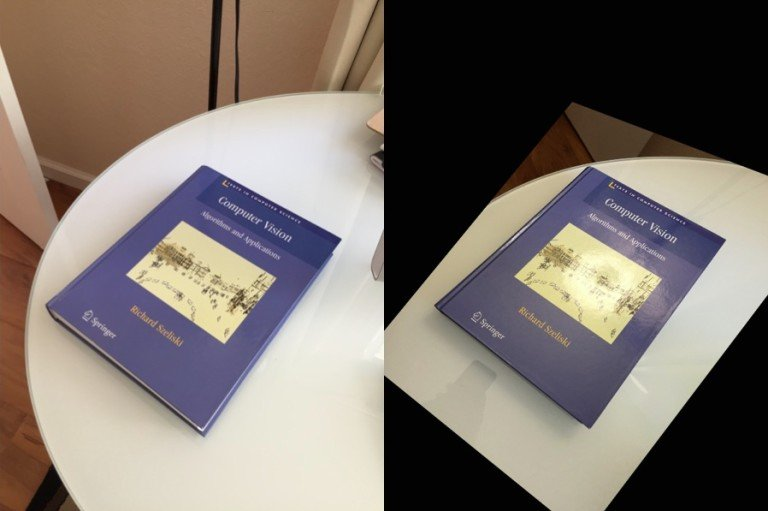

\* *При применении гомографии к одному изображению, второе изображение принимает тот же вид, что и первое за исключением точек, которые не лежат на одной плоскости.*

>* Уравнение верно для всех наборов соответствующих точек, если в реальном мире они лежат на одной плоскости.
>* Если точки не находятся в плоскости, они не будут выровнены с помощью гомографии.
>* Если на изображении две плоскости, тогда есть две гомографии - по одной на каждую плоскость.

**Панорама** - приложение гомографии.

Поскольку на изображении должна быть плоскость, то только фрагмент на плоскости может быть правильно трансформирован. Если  же сделать несколько снимков любой сцены (и не только плоской) с поворотом камеры по горизонтали (как при панораме), то эти трёхмерные изображения будут связаны гомографией. 

На этих изображениях будут некоторые перетекающие друг в друга общие фрагменты, которые могут быть выровнены и сшиты так, что получится панорама из двух изображений. Основной принцип использования гомографии заключается в том, чтобы выравнивать и сшивать изображения так, чтобы швов было не видно.

---

Задание функции, получающей изображения из папки и конвертирующей их в необходимый для дальнейшей обработки формат:

In [3]:
def prepare_images(path: str, convert: bool = True) -> Tuple[List[str], List[np.ndarray]]:
    images = []
    
    for file_name in os.listdir(path):
        images.append(path + file_name)
    
    images = images[::-1]
    
    if convert:
        converted_images = []

        for image in images:
            converted_image = cv2.imread(image)
            converted_images.append(converted_image)
        
        return images, converted_images
        
    return images

Задание функции, выводящей изображения:

In [4]:
def plot_images(images: list, n_cols: int = 5, raw_image: bool = True) -> None: 
    n_images = len(images)
    
    n_rows = n_images // n_cols + (n_images % n_cols * 10) // 10
    n_rows = n_rows if n_rows != 0 else 1
        
    fig = plt.figure(figsize=(16, 10))
    
    for i in range(n_images):
        fig.add_subplot(n_rows, n_cols, i+1)
        
        if raw_image:
            image = plt.imread(images[i])
        else:
            image = images[i]
            
        plt.imshow(image)
        
        plt.xticks([])
        plt.yticks([])
        
    plt.tight_layout()

Задание функции, трансформирующей изображения с помощью гомографии:

In [5]:
def homography_transform(image_1: np.ndarray, image_2: np.ndarray) -> np.ndarray:
    
    # Преобразование изображений в оттенки серого
    gray_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    gray_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

    # Инициализация объекта SIFT (определение ключевых точек)
    sift = cv2.SIFT_create()

    # Нахождение ключевых точек и дескрипторов на обоих изображениях
    key_points_1, descriptors_1 = sift.detectAndCompute(gray_1, None)
    key_points_2, descriptors_2 = sift.detectAndCompute(gray_2, None)

    # Нахождение соответствий между дескрипторами на двух изображениях
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    matches = matcher.knnMatch(descriptors_1, descriptors_2, k=2)

    # Фильтрация соответствий с помощью метрики Lowe's ratio test
    good_matches = []
    
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Нахождение матрицы гомографии
    src_pts = np.float32([key_points_1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([key_points_2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    return H

Задание функции, объединяющей два изображения в панораму:

In [6]:
def create_panorama(image_1, image_2) -> np.ndarray:
    H = homography_transform(image_1, image_2)
    
    # Преобразование изображений
    panorama = cv2.warpPerspective(image_1, H, (image_1.shape[1] + image_2.shape[1], image_2.shape[0]))
    panorama[0:image_2.shape[0], 0:image_2.shape[1]] = image_2
    
    return panorama

Задание функции, объединяющей список изображений в панораму:

In [7]:
def combine_panorama(images: List[np.ndarray]) -> np.ndarray:
    image_1, image_2 = images[0], images[1]
    
    panorama = create_panorama(image_1, image_2)
    
    for i in range(2, len(images)):
        panorama = create_panorama(panorama, images[i])
    
    return panorama

Задание функции, выводящей панораму:

In [8]:
def plot_panorama(panorama: np.ndarray) -> None:
    plt.figure(figsize = (16, 10))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB), interpolation='nearest')

---

Формирование списка фотографий:

In [9]:
images_landscape = prepare_images('data/landscape/')

Выведение на экран исходных фотографий:

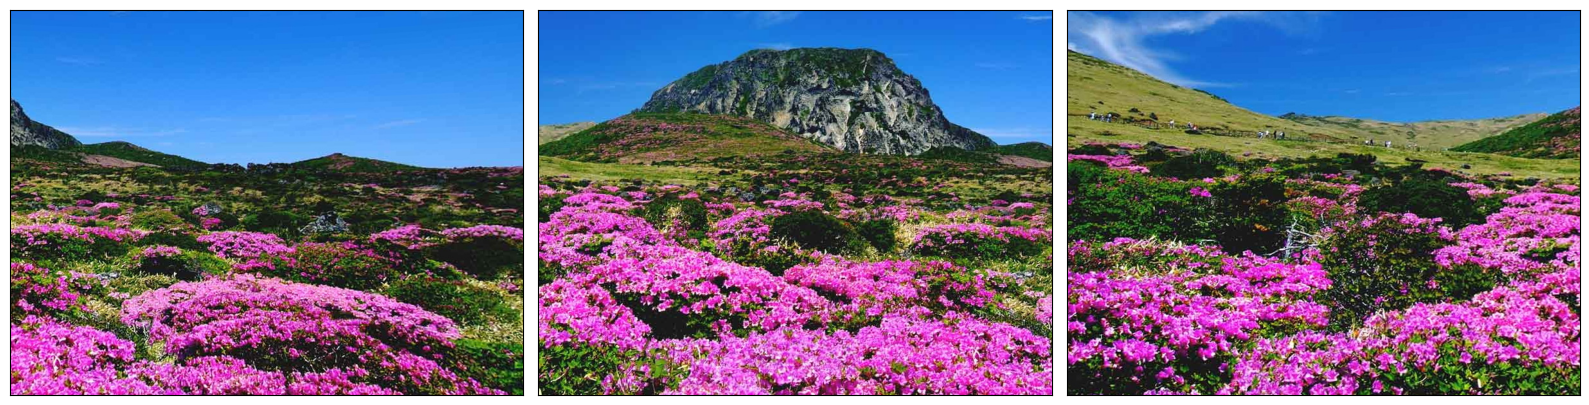

In [10]:
plot_images(images_landscape[0], n_cols=3)

Выведение на экран конвертированных фотографий:

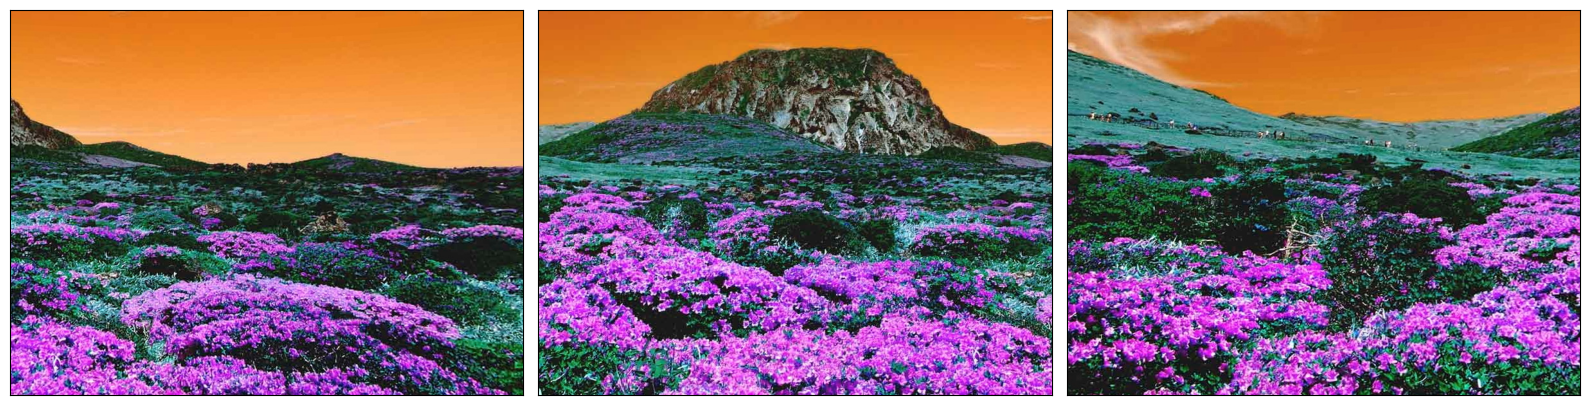

In [11]:
plot_images(images_landscape[1], n_cols=3, raw_image=False)

Формирование панорамы:

In [12]:
panorama_landscape = combine_panorama(images_landscape[1])

Выведение на экран панорамы:

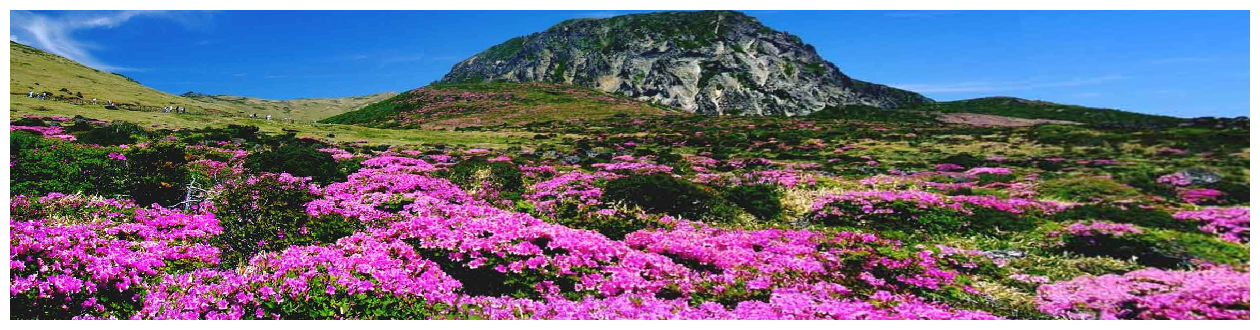

In [13]:
plot_panorama(panorama_landscape)

---

Формирование списка фотографий:

In [14]:
images_mai = prepare_images('data/mai/')

Выведение на экран исходных фотографий:

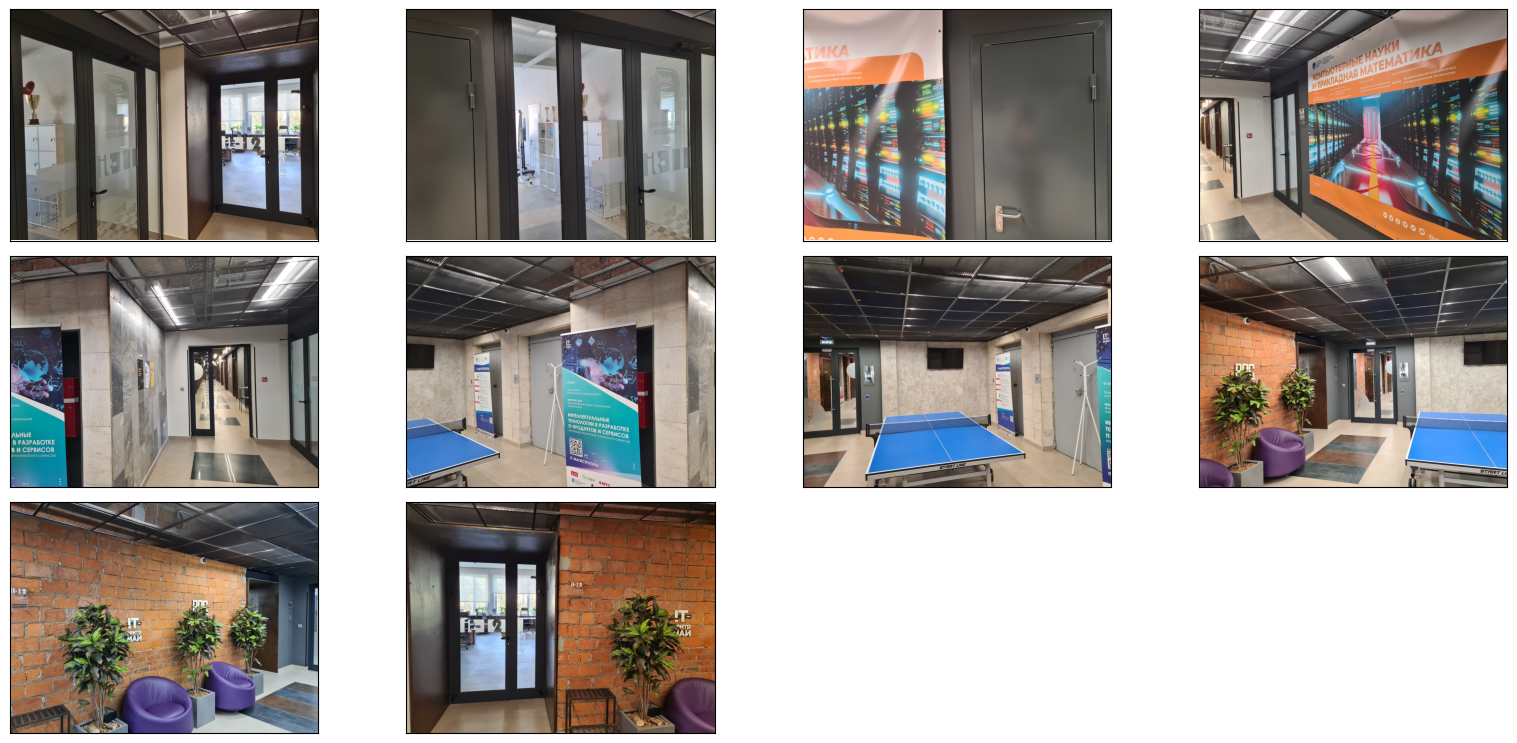

In [15]:
plot_images(images_mai[0], n_cols=4)

Выведение на экран конвертированных фотографий:

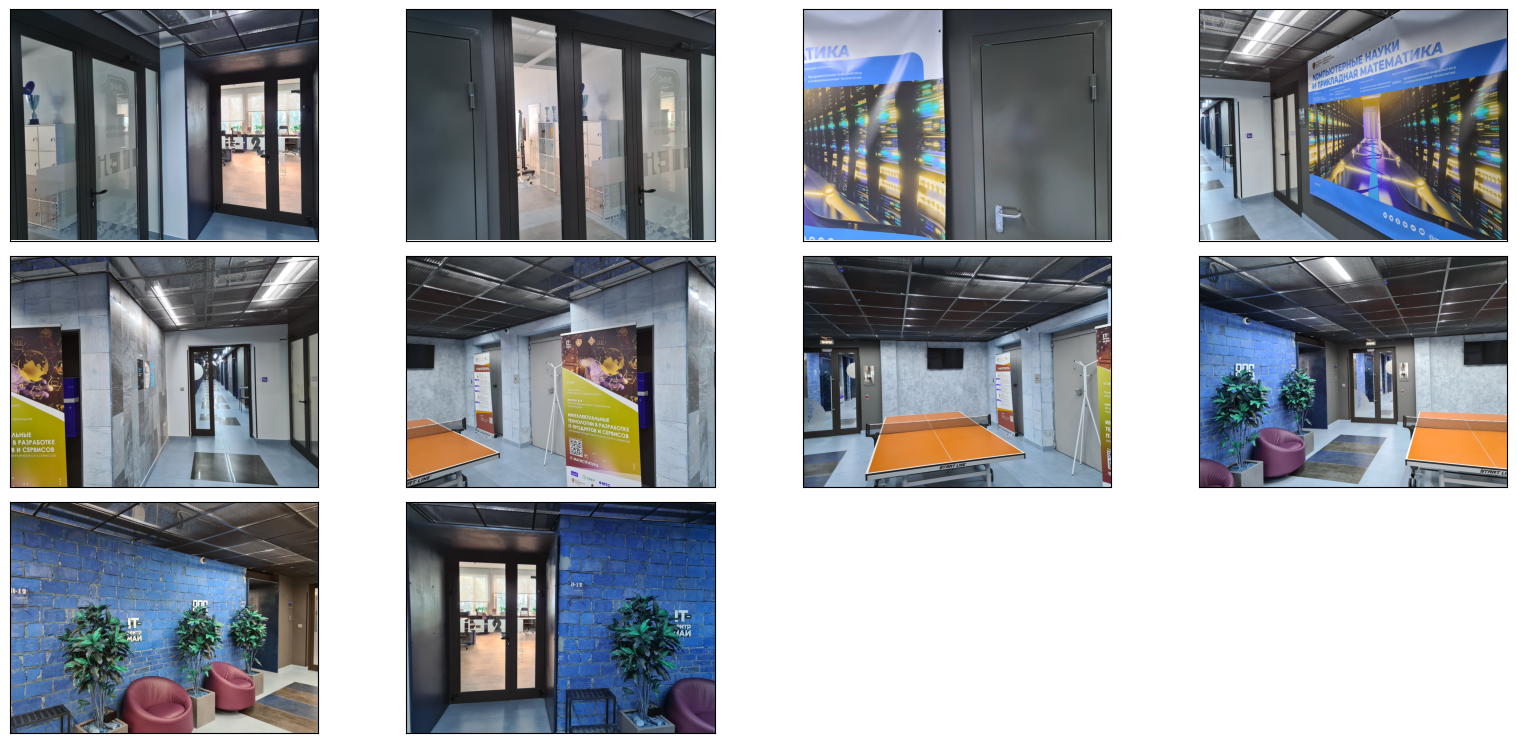

In [16]:
plot_images(images_mai[1], n_cols=4, raw_image=False)

>Фотографий слишком много для формирования панорамы, поскольку процесс напрямую зависит от количества поступающих изображений. Таким образом для создания панорамы будут взяты последние пять изображений.

Формирование панорамы:

In [17]:
panorama_mai = combine_panorama(images_mai[1][-5:])

Выведение на экран панорамы:

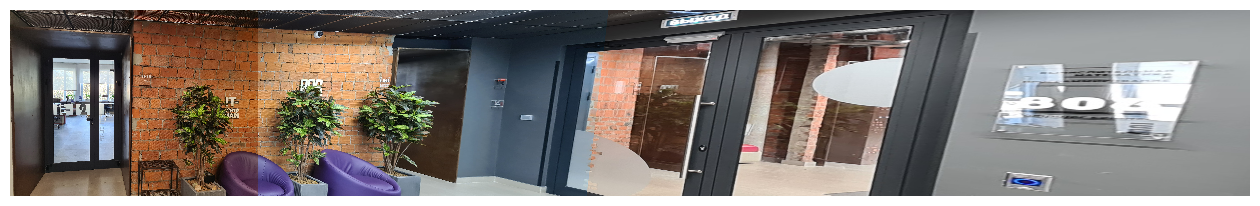

In [18]:
plot_panorama(panorama_mai)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Общий вывод

Был реализован алгоритм смешивания фотографий для создания панорам с помощью гомографии.

Стоит отметить, что чем больше изображений необходимо объединить, тем больше времени занимает этот процесс.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>